# Tracking Workflow
This workflow is designed to expedite manual ROI quality control for inclusion/exclusion from the dataset and to allow for tracking ROIs across multiple days

First, we need to import some important packages. This tracking workflow primarily runs off the open cv computer vision package. To read more about this package see the documentation here: https://pypi.org/project/opencv-python/

In [1]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os 
import cv2


 Next, we need to load in all the images. Right now my data primarily consists of three consecutive days I want to track cells so that is what this workflow is optimized for. To add additional images, (i.e. image 4) the user would need to duplicate the `fname3` line to be for `fname4`.
 
 This is the only cell that requires the user to modify information. Set:
 - `im_dir` to be the source directory of the images
 - `fnameX` to be each day where X corresponds to the day number in the dataset
 - `savename` to be the name to save the tracked ROI point file at the end of tracking

In [43]:
im_dir='C:/Users/stuberadmin/Desktop/project_images' # image path to open

fname1='PL01day1_binary.png'
fname2='PL01day2_binary.png'
fname3='PL01day3_binary.png'


Next, we need to load in all the images. Right now my data primarily consists of three consecutive days I want to track cells so that is what this workflow is optimized for. To add additional images, (i.e. image 4) the user would need to duplicate the `img3=` lins to be for  `img4` as well as to add another column to the plot(`ncols=4`), Day 4 to the title list, and `ax[3].imshow(img4, cmap='gray')`. This structure can be repeated for however many additional images need to be added to the dataset

<ipython-input-2-e48e28607776>:10: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img1=rgb2gray(plt.imread(os.path.join(im_dir, fname1))); # read image 1
<ipython-input-2-e48e28607776>:11: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img2=rgb2gray(plt.imread(os.path.join(im_dir, fname2))); # read image 2
<ipython-input-2-e48e28607776>:12: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img3=rgb2gray(plt.imread(os.path.join(im_dir, fname3))); # read image 3


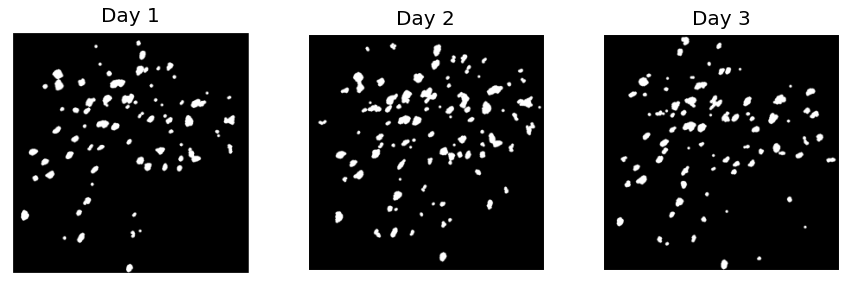

In [2]:
from skimage.util import img_as_ubyte, img_as_float
from skimage.color import rgb2gray, gray2rgb

img1=rgb2gray(plt.imread(os.path.join(im_dir, fname1))); # read image 1
img2=rgb2gray(plt.imread(os.path.join(im_dir, fname2))); # read image 2
img3=rgb2gray(plt.imread(os.path.join(im_dir, fname3))); # read image 3


fig, ax = plt.subplots(ncols=3, figsize=(15,6)) 
titles=('Day 1', 'Day 2', 'Day 3')
for axi, title in zip(ax,titles):
  axi.axis('off')
  axi.set_title(title, fontsize=20)

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray');
ax[2].imshow(img3, cmap='gray');

The mouse click package of OpenCV only allows a single popup window at a time, so we must concatenate all of the images together using the horizontal stacking function (`hstack`) in `numpy`. To add additional images, just add the image name to the list within `hstack` (i.e. to add img4 the line would read `im=np.hstack((img1, img2,img3,img4))`
 Ensure the output image looks correct before proceeding to the next cell.

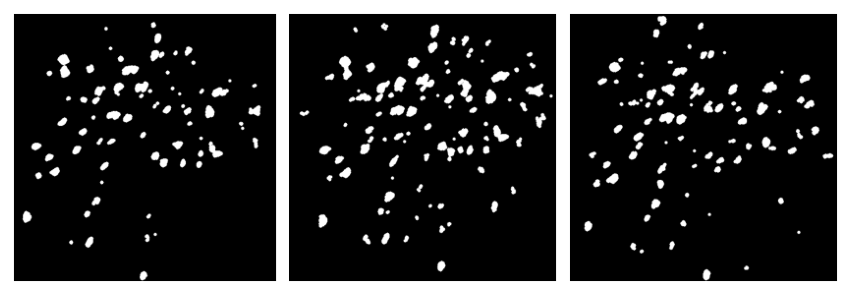

In [51]:
im=np.hstack((img1, img2, img3)) # horizontally concatenate the images

#view the resulting image
fig, ax = plt.subplots(ncols=1, figsize=(15,6)) 
ax.imshow(im, cmap='gray')
ax.axis('off');

Now we need to define the function that will allow us to track cells by clicking on the openCV popup window. When a region is clicked, this function will put the number of the tracked cell on top of the cell and return the x (`mouseX`) and y(`mouseY`) coordinates of the tracked point for storage

In [12]:
def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK: # if left button is double clicked
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(im,str(a),(x-4,y), font, 0.5,(0,0,255),2,cv2.LINE_AA) # put a number near where the click was
        mouseX,mouseY = x,y # store the x and y coordinates of the click
       

The cell below runs the tracking window.
To select a cell, double click the mouse over the cell and press the "a" keyboard button. A number should appear (this number is tracked by `a` in this workflow. the total number of cells with this number is represnted with `b`). Track cells sequentially (i.e. identify Cell 1 on all ROI images before moving on to Cell 2). To close the window, press q. 
The coordinates of each cell region are stored in the structure `coords`

In [13]:
im=gray2rgb(im) 
cv2.namedWindow('image1')
cv2.setMouseCallback('image1',draw_circle)
flag1=0
a=0;
b=1;
coords=np.zeros(2);
while(flag1<1):
    cv2.imshow('image1',im)
    k = cv2.waitKey(20) & 0xFF
    if k == 27:
        flag1=1
    elif k == ord('a'):
        coords=np.hstack((coords, (mouseX, mouseY)))
        if b>2:
            a=a+1
            b=0
        b=b+1
    elif k == ord('q'):
        flag1=1
        coords=np.delete(coords,([0])) # remove initial (0,0) point from array
    
cv2.destroyAllWindows()

After tracking is complete, we need to save the array with the X and Y coordinate of the tracked ROIs for each cell. This can be combined in downstream analysis workflows with the segmented ROIs from the `Segmentation_Workflow` document to extract the signal from neural time series only for regions (i.e. neurons) that are present in the segmented ROI file (with name `sname` from `Segmentation_Workflow`) AND have a point within the segmented region represented in the files saved from this workflow.

Before we can save the files, we need to account for the horizontal concatenation we performed to be able to track all the days in the same window. To do this we subtract the number of columns to the left of the first column of each image (this is 0 for img1, the number of cols in img1 in img2, and the number of cols in img1 and img2 for img3).

In [18]:
# compute widths of concatenated images
row1=(img1.shape[1])
row2=(img2.shape[1])

# separate out mouse click coordinates from individual images
x1=coords[0::6]
y1=coords[1::6]
x2=coords[2::6]-row1 # correct for image 2 is next to image 1
y2=coords[3::6]
x3=coords[4::6]-(row1+row2) # correct for image 3 is next to image 1 and 2
y3=coords[5::6]


Finally, we need to save the images. To do this we vertically concatenate the x and y coordinates for the tracked ROIs in each image and save using the filestring from the image we loaded before the underscore. 

In [50]:
#save the image 1 clicks
s1=fname1.split('_')[0]
day1=np.vstack((x1,y1))
np.save(s1, day1)

#save the image 2 clicks
s2=fname2.split('_')[0]
day2=np.vstack((x2,y2))
np.save(s2, day2)

#save the image 3 clicks
s3=fname3.split('_')[0]
day3=np.vstack((x3,y3))
np.save(s3,day3)